In [16]:
# RBM solver using steepest descent (SD)

In [17]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from numba import jit

In [18]:
## https://stackoverflow.com/questions/26560726/python-binomial-coefficient
@jit(nopython=True)
def binomial(n,r):
    p = 1
    for i in range(1,min(r,n-r) + 1):
        p *= n
        p //= i
        n -= 1
    return p

In [19]:
## https://web.archive.org/web/20190109000030/http://www.hackersdelight.org/hdcodetxt/snoob.c.txt
@jit(nopython=True)
def get_next_same_nup_state(state):
    next = 0
    if(state>0):
        smallest = state & -(state)
        ripple = state + smallest
        ones = state ^ ripple
        ones = (ones >> 2) // smallest
        next = ripple | ones
    return next

In [20]:
def num2bit(state,L):
    return np.binary_repr(state,L)

def bit2num(bit):
    return int(bit,2)

In [21]:
def make_xlist(L,nup,D):
    state = (1<<(L-nup))-1
    xlist = []
    for i in range(D):
#        print(i,state,num2bit(state,L))
        xlist.append([int(x)*2-1 for x in str(num2bit(state,L))])
        state = get_next_same_nup_state(state)
    return np.array(xlist)

In [22]:
## Subroutine for calculating theta 
##  see Eq.(S9) in Supplementary Materials, Carleo and Troyer, Science (2017)
##  \theta_j = \sum_i  W_ij * \sigma_i 
##
## input: sigma[N]
## output: theta[M]
@jit(nopython=True)
def calc_theta(
    sigma, theta,
    alpha, N, M, Wirr,
    ):
#
    W = np.zeros((M,N),dtype=np.float64)
    j = 0
    for f in range(alpha):## loop for independent neuron
        for jj in range(1,N+1):## we have N copies of hidden units because of translational symmetry
            j += 1
            theta[j-1] = 0.0
            for i in range(1,N+1):
                ## set W_ij using translational symmetry
                iw = i - jj
                if iw<0:
                    iw += N
                W[j-1,i-1] = Wirr[f-1,iw]
                ## calculate theta
                theta[j-1] += W[j-1,i-1] * sigma[i-1]
    return 0

In [23]:
## input: M ## number of hidden units
## input: theta[M] ## \theta_j = \sum_i  W_ij * \sigma_i
## output: psi_x ## <x|psi> (|x> = |sigma_1, sigma_2, ..., sigma_N>) 
@jit(nopython=True)
def calc_amplitude_RBM(M,theta,psi_x,ix):
    ## When bias terms are zero, wave function is given by 
    ##  psi_x = \prod_j 2 * cosh(\theta_j)
    tmp = 1.0
    for j in range(M):
        tmp = tmp * np.cosh(theta[j]) ## neglect irrelevant factor of 2
    psi_x[ix] = tmp
    return 0

In [24]:
@jit(nopython=True)
def RBM_solver(
    alpha, Nstep, delta_tau,
    L, D,
    xlist,
    ):
#
    N  = L          # number of visible units 
    M  = alpha * N  # number of hidden units
    Nv = alpha * N  # number of variational parameters
    theta = np.zeros(M,dtype=np.float64)
    thetap = np.zeros(M,dtype=np.float64)
    gvec = np.zeros(Nv,dtype=np.float64)
    Ovec = np.zeros(Nv,dtype=np.float64)
    Ovec_loc_x = np.zeros(Nv,dtype=np.float64)
    Es = np.zeros(Nstep,dtype=np.float64)
#
## initialize W (variational parameters)   
## put random numbers between -0.01 and 0.01
## [original code: Wirr(0:N-1,alpha)]
    rnd_amp = 0.01
##----
## without numba: read file 
#    Wirr = np.loadtxt("_input_initial_W.txt")[:,2].reshape(alpha,N)
#    print(Wirr)
## without numba
#    rng = np.random.default_rng(12345)
#    Wirr = rng.uniform(-rnd_amp,rnd_amp,(alpha,N))
#    print(Wirr)
## with numba
    np.random.seed(1234567)
    Wirr = np.random.uniform(-rnd_amp,rnd_amp,(alpha,N))
#    print(Wirr)
##----
    init_f_iw_Wirr = [[f,iw,Wirr[f,iw]] for f in range(alpha) for iw in range(N)]
#    np.savetxt("initial_W.txt",f_iw_Wirr,
#        header="index for interaction (iw), index for independent neurons (f), irreducible interaction Wirr(f,iw)")
#
## initial wave function
    psi = np.zeros(D,dtype=np.float64)
    psip = np.zeros(D,dtype=np.float64)
    for ix in range(D):
        calc_theta(xlist[ix],theta,alpha,N,M,Wirr)
        calc_amplitude_RBM(M,theta,psi,ix)
    psi = psi/np.linalg.norm(psi)
#    print(psi)
#    init_psi = copy.deepcopy(psi) ## not working with numba
    init_psi = np.zeros(D,dtype=np.float64)
    init_psi[:] = psi[:]
#    print(init_psi)
#    np.savetxt("initial_wf.txt",psi,
#        header="initial wave function psi(x), order of x follows that in Fock_state_list.txt")
#
## start optimization
    for iteration in range(Nstep):
        gvec = np.zeros(Nv,dtype=np.float64)
        Ovec = np.zeros(Nv,dtype=np.float64)
        E = 0.0
        for ix in range(D):
            ## calculate wave function psi(x)
            calc_theta(xlist[ix],theta,alpha,N,M,Wirr)
            calc_amplitude_RBM(M,theta,psi,ix)
            p_x = psi[ix]**2
            ## calculate Eloc(x) and take sum over x for E
            ## H = J ( SzSz - SxSx - SySy ) after the gauge transformation
            Eloc_x = 0.0
            for i1 in range(N):
                i2 = (i1+1)%N
                ## SzSz
                Eloc_x += xlist[ix,i1] * xlist[ix,i2]
                ## - SxSx - SySy
                if xlist[ix,i1] != xlist[ix,i2]:
                    xlist[ix,i1] *= -1
                    xlist[ix,i2] *= -1
                    calc_theta(xlist[ix],thetap,alpha,N,M,Wirr)
#                    print(thetap)
                    calc_amplitude_RBM(M,thetap,psip,ix)
                    Eloc_x -= 2.0*psip[ix]/psi[ix]
#                    print(psi[ix],psip[ix],2.0*psip[ix]/psi[ix],Eloc_x)
                    xlist[ix,i1] *= -1
                    xlist[ix,i2] *= -1
            E += p_x * Eloc_x
            ## calculate Ovec_loc_x
            k = 0
            for f in range(1,alpha+1):
                for iw in range(N):
                    k += 1
                    Ovec_loc_x[k-1] = 0.0
                    for jj in range(1,N+1):
                        j = (f-1)*N + jj
                        i = jj + iw
                        if i > N:
                            i -= N
                        Ovec_loc_x[k-1] += np.tanh(theta[j-1])*xlist[ix,i-1]
            if k!= Nv:
                print("# error: k!=Nv",k,Nv)
                break
            ## summation over x for gvec and ovec
            for k in range(Nv):
                gvec[k] += 2.0 * p_x * Eloc_x * Ovec_loc_x[k]
                Ovec[k] += p_x * Ovec_loc_x[k]
        ## Dividing by <psi|psi> (=norm), we get
        ##  gvec(k) = 2 <H*O_k>
        ##  Ovec(k) = <O_k>
        ##  E = <H>
        norm = np.linalg.norm(psi)**2
#        print(norm)
        gvec /= norm
        Ovec /= norm
        E /= norm
#        print(iteration,E)
        Es[iteration] = E
        ## gvec(k) = 2 <H*O_k> - 2 <H> <O_k>
        for k in range(Nv):
            gvec[k] -= 2.0 * E * Ovec[k]
        ## update W (variational parameters)
        delW_max_eps = 0.003
        delW_max = np.max(np.abs(delta_tau*gvec))
#        print(delW_max)
#        print(Wirr)
        k = 0
        for f in range(alpha):
            for iw in range(N):
                k += 1
                if delW_max > delW_max_eps:
                    Wirr[f,iw] -= delta_tau * gvec[k-1] * delW_max_eps/delW_max
                else:
                    Wirr[f,iw] -= delta_tau * gvec[k-1]
#        print(Wirr)
#        print()
#        print(gvec)
#
## optimzed W
    opt_f_iw_Wirr = [[f,iw,Wirr[f,iw]] for f in range(alpha) for iw in range(N)]
#
## optimzed wave function
    for ix in range(D):
        calc_theta(xlist[ix],theta,alpha,N,M,Wirr)
        calc_amplitude_RBM(M,theta,psi,ix)
    psi = psi/np.linalg.norm(psi)
#    print(psi)
#
    return init_f_iw_Wirr, init_psi, opt_f_iw_Wirr, psi, Es

In [25]:
def main():
    # hidden variable density, number of optimization step, delta_tau
    alpha = 1
    Nstep = 5000
    #Nstep = 1000
    delta_tau = 0.001
    print("alpha",alpha)
    print("Nstep",Nstep)
    print("delta_tau",delta_tau)

    # system size, dimension of Hilbert space (total_Sz=0 sector)
    L = 8
    nup = L//2
    D = binomial(L,nup)
    print("L",L)
    print("D",D)

    # make xlist for total_Sz=0 sector
    xlist = make_xlist(L,nup,D)
    #print("xlist",xlist)
    print("xlist.shape",xlist.shape)
    #print("xlist[D-1]",xlist[D-1])
    #print("xlist[:,0]",xlist[:,0])
    np.savetxt("Fock_state_list.txt",xlist,fmt="%i",
        header="system size, dimension of Hibert space: "+"{}, ".format(L)+"{}".format(D))

    init_f_iw_Wirr, init_psi, opt_f_iw_Wirr, opt_psi, Es = RBM_solver(alpha,Nstep,delta_tau,L,D,xlist)
    #print(Es)
    print("energy",Es[Nstep-1])
    np.savetxt("energy.txt",Es)
    np.savetxt("initial_W.txt",init_f_iw_Wirr,
        header="index for interaction (iw), index for independent neurons (f), irreducible interaction Wirr(f,iw)")
    np.savetxt("initial_wf.txt",init_psi,
        header="initial wave function psi(x), order of x follows that in Fock_state_list.txt")
    np.savetxt("optimized_W.txt",opt_f_iw_Wirr,
        header="index for interaction (iw), index for independent neurons (f), irreducible interaction Wirr(f,iw)")
    np.savetxt("optimized_wf.txt",opt_psi,
        header="optimized wave function psi(x), order of x follows that in Fock_state_list.txt")

    plt.xlabel("Nstep")
    plt.ylabel("E")
    plt.plot(np.arange(Nstep),Es)
    plt.show()
    plt.close()

#    exact_psi = np.loadtxt("ref_exact_ground_state.txt")
    exact_psi = np.array([0.007469660603699186,0.03474208920086307,0.05454485719432777,0.03474208920086304,0.007469660603699169,0.05454485719432794,0.16440627939276697,0.1371338507956024,0.034742089200862976,0.09005865420497404,0.16440627939276575,0.054544857194327404,0.05454485719432748,0.03474208920086299,0.007469660603699175,0.03474208920086324,0.13713385079560247,0.16440627939276584,0.05454485719432743,0.16440627939276606,0.39829673718725694,0.16440627939276561,0.16440627939276564,0.13713385079560225,0.03474208920086302,0.05454485719432754,0.1644062793927659,0.0900586542049739,0.13713385079560225,0.16440627939276675,0.05454485719432777,0.0347420892008631,0.05454485719432794,0.034742089200863156,0.007469660603699187,0.007469660603699139,0.03474208920086305,0.05454485719432737,0.03474208920086294,0.05454485719432746,0.16440627939276553,0.1371338507956021,0.09005865420497378,0.16440627939276647,0.05454485719432773,0.034742089200863045,0.13713385079560228,0.16440627939276684,0.16440627939276672,0.39829673718726066,0.16440627939276675,0.05454485719432781,0.1644062793927671,0.13713385079560253,0.03474208920086305,0.007469660603699138,0.03474208920086321,0.054544857194327875,0.05454485719432788,0.16440627939276714,0.09005865420497398,0.03474208920086324,0.1371338507956028,0.16440627939276609,0.05454485719432754,0.007469660603699172,0.034742089200863115,0.05454485719432755,0.03474208920086305,0.007469660603699139])
    plt.xlabel("basis index")
    plt.ylabel("amplitude")
    plt.plot(np.arange(D),exact_psi,label="exact")
    plt.plot(np.arange(D),init_psi,label="init")
    plt.plot(np.arange(D),opt_psi,label="opt",marker="o",ls="none")
    plt.legend()
    plt.show()
    plt.close()

alpha 1
Nstep 5000
delta_tau 0.001
L 8
D 70
xlist.shape (70, 8)
energy -14.604142284384855


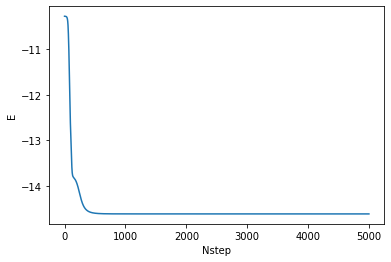

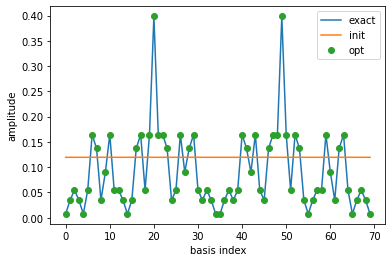

In [26]:
main()